In [183]:
import pandas as pd
import sklearn
import shap
import numpy as np
import matplotlib as plt

from sklearn import metrics
from sklearn.impute import SimpleImputer

from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [184]:
train=pd.read_csv('cs-training.csv')
test=pd.read_csv('cs-test.csv')
train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [185]:
train=train.drop(['Unnamed: 0'], axis=1)
df_vars=['SeriousDlqin2yrs','RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse',
         'DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',
         'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']

In [186]:
train2=train.copy()
imp = SimpleImputer(missing_values=np.nan, strategy='median')
train2 = imp.fit_transform(train)
train2=pd.DataFrame(train2,columns=df_vars)
train2.loc[train["age"] == 0, "age"] = train2.age.median()

In [187]:
train2["MonthlyDebtPayments"] = train2["DebtRatio"] * train2["MonthlyIncome"]
train2["MonthlyDebtPayments"] = np.absolute(train2["MonthlyDebtPayments"])
train2["MonthlyDebtPayments"] = train2["MonthlyDebtPayments"].astype('int64')

In [188]:
model=sklearn.ensemble.GradientBoostingClassifier(loss='deviance',verbose=1)
y=[int(i) for i in np.array(train2['SeriousDlqin2yrs'])]
model_vars=['RevolvingUtilizationOfUnsecuredLines','age','NumberOfTime30-59DaysPastDueNotWorse',
         'DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans','NumberOfTimes90DaysLate','NumberRealEstateLoansOrLines',
         'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents','MonthlyDebtPayments']
X=np.array(train2[model_vars])

In [189]:
model_fit=model.fit(X,y)

      Iter       Train Loss   Remaining Time 
         1           0.4578           11.38s
         2           0.4390           11.78s
         3           0.4260           11.42s
         4           0.4164           10.79s
         5           0.4082           10.74s
         6           0.4023           10.41s
         7           0.3966           10.37s
         8           0.3922           10.14s
         9           0.3881            9.92s
        10           0.3848            9.74s
        20           0.3677            8.70s
        30           0.3611            7.89s
        40           0.3579            6.77s
        50           0.3557            5.67s
        60           0.3540            4.51s
        70           0.3529            3.36s
        80           0.3521            2.25s
        90           0.3515            1.12s
       100           0.3510            0.00s


In [190]:
pred=model_fit.predict_proba(X)[:,1]
auc=metrics.roc_auc_score(y,pred)
print("Train SD: {}".format((auc*2)-1))


Train SD: 0.7372722857644152


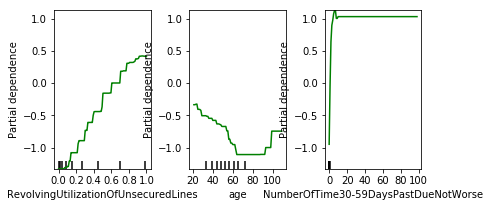

In [191]:
features=[0,1,2]
fig, axs=plot_partial_dependence(model_fit, train2[model_vars], features,
                                feature_names=model_vars,
                                n_jobs=3,grid_resolution=100)

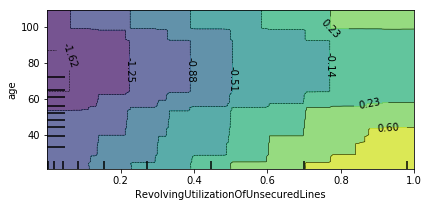

In [192]:
features=[(0,1)]

fig, axs=plot_partial_dependence(model_fit, train2[model_vars], features,
                                feature_names=model_vars,
                                n_jobs=3,grid_resolution=100)

In [193]:
shap.initjs()

In [194]:
explainer=shap.TreeExplainer(model_fit)

In [195]:
shap_values=explainer.shap_values(train2[model_vars])

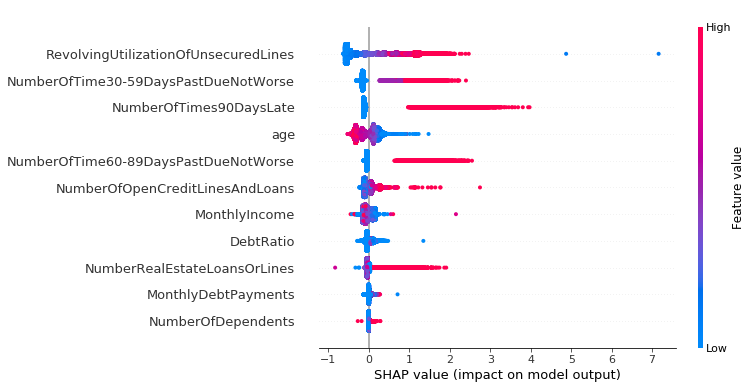

In [196]:
shap.summary_plot(shap_values, train2[model_vars])

In [197]:
shap_df=pd.DataFrame(shap_values, columns=model_vars)

In [198]:
shap_df.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebtPayments
0,0.836026,0.115642,1.230186,0.242016,-0.082972,0.062360,-0.094352,0.874585,-0.037478,0.005771,-0.014532
1,1.215788,0.222779,-0.167937,-0.049456,0.140920,-0.135329,-0.116289,0.016789,-0.056886,-0.006558,-0.004244
2,0.516857,0.168921,0.481529,-0.065078,0.156086,-0.090445,1.652834,0.015546,-0.081787,-0.013406,-0.017772
3,-0.098123,0.237966,-0.161573,-0.056444,0.126112,-0.125593,-0.127524,0.003598,-0.057290,-0.017945,-0.004370
4,1.099607,0.101515,0.657078,-0.083192,-0.143141,-0.101850,-0.104671,-0.039168,-0.052106,-0.005692,-0.005836


In [199]:
train2['avg_shap'] = shap_df.mean(axis=1)
train2['sum_shap'] = shap_df.sum(axis=1)

In [200]:
train2.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebtPayments,avg_shap,sum_shap
0,1.0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0,7323,0.285205,3.137253
1,0.0,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0,316,0.096325,1.059577
2,0.0,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0,258,0.247571,2.723285
3,0.0,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0,118,-0.025562,-0.281185
4,0.0,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0,1584,0.120231,1.322546


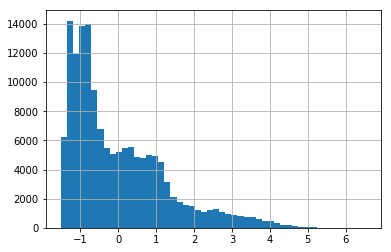

In [250]:
train2['sum_shap'].hist(bins=50)

In [202]:
#select customers with high shap
hi_shap_cust=train2[train2['avg_shap']>0.317]
hi_shap_cust.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebtPayments,avg_shap,sum_shap
count,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3.067000e+03,3067.000000,3067.000000
mean,0.634170,4.179029,43.465276,8.148679,255.423501,4792.152592,6.585589,8.315618,0.823606,7.395174,1.036844,1.308173e+06,0.361471,3.976179
std,0.481741,103.242826,11.484966,23.587537,972.112121,3905.078793,4.981515,23.558012,1.371546,23.755626,1.273294,4.931685e+06,0.036229,0.398517
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.317031,3.487340
25%,0.000000,0.908897,35.000000,1.000000,0.207752,3000.000000,3.000000,1.000000,0.000000,0.000000,0.000000,7.645000e+02,0.332380,3.656184
50%,1.000000,1.000000,43.000000,2.000000,0.498111,4545.000000,5.000000,2.000000,0.000000,1.000000,1.000000,1.974000e+03,0.353478,3.888262
75%,1.000000,1.043095,51.000000,3.000000,1.079011,5400.000000,9.000000,3.000000,1.000000,2.000000,2.000000,5.212000e+03,0.381162,4.192779
max,1.000000,3818.000000,91.000000,98.000000,18560.000000,141500.000000,40.000000,98.000000,14.000000,98.000000,8.000000,1.002240e+08,0.592303,6.515336


In [269]:
#select customers with high shap
low_shap_cust=train2[train2['sum_shap']<-1.3]
low_shap_cust.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebtPayments,avg_shap,sum_shap
count,11758.000000,11758.000000,11758.000000,11758.0,11758.000000,11758.000000,11758.000000,11758.0,11758.000000,11758.0,11758.000000,1.175800e+04,11758.000000,11758.000000
mean,0.003657,0.029983,72.233883,0.0,396.452999,6828.834070,5.576884,0.0,0.618473,0.0,0.187447,2.079871e+06,-0.124513,-1.369646
std,0.060366,0.030125,8.014461,0.0,3133.761132,8170.310244,2.095654,0.0,0.702035,0.0,0.489827,1.686058e+07,0.004154,0.045694
min,0.000000,0.000000,56.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000e+00,-0.137083,-1.507914
25%,0.000000,0.004618,66.000000,0.0,0.061951,5400.000000,4.000000,0.0,0.000000,0.0,0.000000,2.567500e+02,-0.127487,-1.402352
50%,0.000000,0.020998,71.000000,0.0,0.300672,5400.000000,6.000000,0.0,0.000000,0.0,0.000000,2.189500e+03,-0.123782,-1.361597
75%,0.000000,0.047050,78.000000,0.0,83.750000,7000.000000,7.000000,0.0,1.000000,0.0,0.000000,3.834000e+05,-0.121750,-1.339253
max,1.000000,0.186991,105.000000,0.0,326442.000000,629000.000000,13.000000,0.0,3.000000,0.0,7.000000,1.762787e+09,-0.118193,-1.300122


In [208]:
hi_shap_cust_sort=hi_shap_cust.sort_values(by='avg_shap', ascending=False)
s=explainer.shap_values(hi_shap_cust_sort[model_vars])
i=0
shap.force_plot(explainer.expected_value, s[i,:],hi_shap_cust_sort[model_vars].iloc[i,:],link="logit")

In [206]:
hi_shap_cust_sort.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebtPayments,avg_shap,sum_shap
9016,1.0,0.114584,61.0,0.0,0.220978,10000.0,11.0,0.0,1.0,0.0,0.0,2209,0.592303,6.515336
68537,1.0,0.908082,26.0,3.0,1.444855,6500.0,22.0,1.0,4.0,8.0,0.0,9391,0.538510,5.923611
15260,1.0,1.101803,48.0,3.0,0.926512,4612.0,12.0,5.0,5.0,2.0,3.0,4273,0.538508,5.923593
107593,1.0,0.963327,49.0,6.0,1.726819,6416.0,15.0,2.0,8.0,3.0,0.0,11079,0.532620,5.858824
26031,1.0,1.071890,53.0,3.0,1.408892,11200.0,17.0,0.0,8.0,1.0,1.0,15779,0.508855,5.597402


In [212]:
low_shap_cust_sort=low_shap_cust.sort_values(by='avg_shap', ascending=True)
s=explainer.shap_values(low_shap_cust_sort[model_vars])
i=0
shap.force_plot(explainer.expected_value, s[i,:],low_shap_cust_sort[model_vars].iloc[i,:],link="logit")

In [214]:
s=train2.sample(n=1000, random_state=123)
sample_shap_values=explainer.shap_values(s[model_vars])
shap.force_plot(explainer.expected_value, sample_shap_values, s[model_vars], link="logit")

In [337]:
#lending based on income
train2=train2.sort_values(by='MonthlyIncome', ascending=False)
hi_income_cust=train2.head(n=10000)
#hi_income_cust.head()
hi_income_cust.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyDebtPayments,avg_shap,sum_shap
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.04540,19.039245,54.106100,0.266400,0.282171,2.075174e+04,11.367300,0.049500,1.953700,0.056800,1.244700,4827.928900,-0.016711,-0.183824
std,0.20819,620.261787,10.426779,1.216708,0.627982,4.671571e+04,5.848112,1.031192,1.757005,1.023269,1.293595,9613.068518,0.096894,1.065834
min,0.00000,0.000000,23.000000,0.000000,0.000000,1.240000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.136799,-1.504791
25%,0.00000,0.040256,47.000000,0.000000,0.140558,1.350000e+04,7.000000,0.000000,1.000000,0.000000,0.000000,2382.750000,-0.091446,-1.005904
50%,0.00000,0.151097,54.000000,0.000000,0.239147,1.541600e+04,10.000000,0.000000,2.000000,0.000000,1.000000,3916.500000,-0.046264,-0.508909
75%,0.00000,0.455622,62.000000,0.000000,0.352757,1.925000e+04,14.000000,0.000000,2.000000,0.000000,2.000000,5837.000000,0.041034,0.451373
max,1.00000,50708.000000,94.000000,98.000000,35.440782,3.008750e+06,57.000000,98.000000,32.000000,98.000000,10.000000,478450.000000,0.493447,5.427917


In [351]:
def model_loss(dr,var,n,lv,ir):
    #dr: default rate
    #n: number of loans
    #lv: loan value
    #ir: interest rate
    #assume lgd=0.6
    
    lgd=0.6
    total=n*lv*(1+ir)
    exp_loss=[]

    eff=[]
    for i in range(len(dr)):
        lgdc=lgd/(1+1/(n**0.2))
        t=round((dr[i]+var[i])*(n*lv)*lgdc,0)
        exp_loss.append(t)
        
    exp_loss.append(total)
    base_loss=exp_loss[0]
    for j in range(len(dr)):
        ei=round((exp_loss[j]-base_loss)/exp_loss[j]*100,0)
        mi=round(((total-base_loss)-(total-exp_loss[j]))/(total-exp_loss[j])*100,1)
        exp_loss.append(mi)
    
    
    return exp_loss

In [355]:
out=model_loss([0.003657,0.5,0.0454],[0.060366,0,0.20819],1000,1500,0.05)
print(out)

[46053.0, 359658.0, 182411.0, 1575000.0, 0.0, 25.8, 9.8]


In [356]:
out=model_loss([0.003657,0.5,0.0454],[0.060366,0,0.20819],10000,1500,0.05)
print(out)

[497378.0, 3884369.0, 1970074.0, 15750000.0, 0.0, 28.5, 10.7]
